In [1]:
import keras
from keras.layers import Input, Conv1D,Activation,MaxPooling1D,Dense,Flatten,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,load_model
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [85]:
def get_sub_model(myinputs,channel=3,sensors=1):
    x     = Conv1D(filters =8*sensors, kernel_size=5,strides = 1, padding = 'same')(myinputs)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=3,strides = 2,padding='same')(x)
    #  x shape is 64X16 =3072
    x     = Conv1D(filters =12*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    #  x shape is 32X24 = 2048
    x     = Conv1D(filters =16*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 16*32 = 1536
    x     = Conv1D(filters =20*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 8*32 = 1024
    x     = Conv1D(filters =24, kernel_size=3,strides = 2, padding = 'same')(x)
    # x shape is 4*32 = 512

    latent_vector = Flatten()(x)
    # decoder x = 4*128
    x     = Conv1D(filters =24*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 8*128
    x     = Conv1D(filters =20*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 16*96
    x     = Conv1D(filters =16*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 32*64
    x     = Conv1D(filters =12*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 64*48
    x     = Conv1D(filters =8*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 128*48
    y     = Conv1D(filters =channel, kernel_size=3,strides = 1, padding = 'same')(x)
    #y     = Activation('relu')(x)
    return latent_vector,y

In [106]:
def build_model(name="push_detect",channel=3,sensors=1,inputLength=128):
    # input shape 128X26 =3382
    with tf.name_scope(name):
        myInputs = Input(shape=(inputLength,channel))
                
        LV,Y = get_sub_model(myInputs,channel=channel,sensors=sensors)
        
        autoencoder = Model (inputs=myInputs,
                             outputs =Y)
    
    return autoencoder

In [107]:
inputLength=64
gyroModel=build_model(sensors=3,inputLength=inputLength)
linearAccModel=build_model(sensors=3,inputLength=inputLength)
gravityModel=build_model(sensors=3,inputLength=inputLength)
gameVecModel=build_model(channel=4,sensors=3,inputLength=inputLength)


In [108]:
gyroModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 64, 3)             0         
_________________________________________________________________
conv1d_441 (Conv1D)          (None, 64, 24)            384       
_________________________________________________________________
batch_normalization_145 (Bat (None, 64, 24)            96        
_________________________________________________________________
activation_369 (Activation)  (None, 64, 24)            0         
_________________________________________________________________
max_pooling1d_161 (MaxPoolin (None, 32, 24)            0         
_________________________________________________________________
conv1d_442 (Conv1D)          (None, 32, 36)            2628      
_________________________________________________________________
batch_normalization_146 (Bat (None, 32, 36)            144       
__________

In [6]:
gyroModel=load_model('gyroModel.h5')
linearAccModel=load_model('linearAccModel.h5')
gravityModel=load_model('gravityModel.h5')
gameVecModel=load_model('gameVecModel.h5')


In [110]:
opt = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.000, nesterov=False)
gyroModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=.1, momentum=0.0, decay=0.000, nesterov=False)
linearAccModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=.1, momentum=0.0, decay=0.000, nesterov=False)
gravityModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=.1, momentum=0.0, decay=0.000, nesterov=False)
gameVecModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])

In [109]:
data= np.load('watch_norm.npy')
np.random.shuffle(data)
p=0.85
train_num =int(data.shape[0]*p)
gyro_train=data[:train_num,:inputLength,0:3]
linearAcc_train=data[:train_num,:inputLength,3:6]
gravity_train=data[:train_num,:inputLength,6:9]
gameVec_train=data[:train_num,:inputLength,9:13]

gyro_test =data[train_num:,:inputLength,0:3]
linearAcc_test =data[train_num:,:inputLength,3:6]
gravity_test =data[train_num:,:inputLength,6:9]
gameVec_test =data[train_num:,:inputLength,9:13]

In [111]:
train_round =50
epochs_per_round=20
for i in range(train_round):
    print('start training round '+str(i))
    print('training gyro model')
    gyroModel.fit(gyro_train,gyro_train,
                  batch_size=256,
                  epochs=(i+1)*epochs_per_round,
                  validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    print('training linearAcc model')
    linearAccModel.fit(linearAcc_train,linearAcc_train,
                       batch_size=256,
                       epochs=(i+1)*epochs_per_round,validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    print('training gravity model')
    gravityModel.fit(gravity_train,gravity_train,
                     batch_size=256,
                     epochs=(i+1)*epochs_per_round,validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    print('training gameVec model')
    gameVecModel.fit(gameVec_train,gameVec_train,
                     batch_size=256,
                     epochs=(i+1)*epochs_per_round,validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    gyroModel.save('gyroNorModel_64.h5')
    linearAccModel.save('linearAccNorModel_64.h5')
    gravityModel.save('gravityNorModel_64.h5')
    gameVecModel.save('gameVecNorModel_64.h5')

start training round 0
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/20
8564/8564 [==============================] - 27s 3ms/step - loss: 0.2041 - acc: 0.3522 - val_loss: 0.1907 - val_acc: 0.3348
Epoch 2/20
8564/8564 [==============================] - 4s 478us/step - loss: 0.0898 - acc: 0.3761 - val_loss: 0.1194 - val_acc: 0.3612
Epoch 3/20
8564/8564 [==============================] - 4s 495us/step - loss: 0.0795 - acc: 0.3810 - val_loss: 0.1178 - val_acc: 0.3608
Epoch 4/20
8564/8564 [==============================] - 4s 499us/step - loss: 0.0785 - acc: 0.3953 - val_loss: 0.1085 - val_acc: 0.3095
Epoch 5/20
8564/8564 [==============================] - 4s 491us/step - loss: 0.0758 - acc: 0.3938 - val_loss: 0.0928 - val_acc: 0.2887
Epoch 6/20
8564/8564 [==============================] - 4s 486us/step - loss: 0.0725 - acc: 0.4003 - val_loss: 0.0861 - val_acc: 0.3157
Epoch 7/20
8564/8564 [==============================] - 4s 479us/step - loss: 0.0693 - acc: 0.4

8564/8564 [==============================] - 5s 536us/step - loss: 0.0525 - acc: 0.9567 - val_loss: 0.0549 - val_acc: 0.9612
Epoch 20/20
8564/8564 [==============================] - 5s 535us/step - loss: 0.0538 - acc: 0.9569 - val_loss: 0.0556 - val_acc: 0.9602
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/20
8564/8564 [==============================] - 25s 3ms/step - loss: 0.2691 - acc: 0.5070 - val_loss: 0.1966 - val_acc: 0.6013
Epoch 2/20
8564/8564 [==============================] - 5s 545us/step - loss: 0.1260 - acc: 0.7091 - val_loss: 0.1516 - val_acc: 0.7052
Epoch 3/20
8564/8564 [==============================] - 5s 544us/step - loss: 0.1056 - acc: 0.7622 - val_loss: 0.1366 - val_acc: 0.7338
Epoch 4/20
8564/8564 [==============================] - 4s 497us/step - loss: 0.0946 - acc: 0.7956 - val_loss: 0.1116 - val_acc: 0.7974
Epoch 5/20
8564/8564 [==============================] - 5s 528us/step - loss: 0.0875 - acc: 0.8121 - val_loss: 0.0990 - val_a

8564/8564 [==============================] - 5s 544us/step - loss: 0.0384 - acc: 0.7963 - val_loss: 0.0395 - val_acc: 0.7947
Epoch 38/40
8564/8564 [==============================] - 4s 515us/step - loss: 0.0380 - acc: 0.7993 - val_loss: 0.0365 - val_acc: 0.8003
Epoch 39/40
8564/8564 [==============================] - 4s 513us/step - loss: 0.0378 - acc: 0.7998 - val_loss: 0.0364 - val_acc: 0.8024
Epoch 40/40
8564/8564 [==============================] - 4s 497us/step - loss: 0.0378 - acc: 0.8010 - val_loss: 0.0372 - val_acc: 0.8017
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 21/40
8564/8564 [==============================] - 5s 526us/step - loss: 0.0534 - acc: 0.9563 - val_loss: 0.0541 - val_acc: 0.9542
Epoch 22/40
8564/8564 [==============================] - 5s 538us/step - loss: 0.0544 - acc: 0.9586 - val_loss: 0.0603 - val_acc: 0.9602
Epoch 23/40
8564/8564 [==============================] - 5s 534us/step - loss: 0.0529 - acc: 0.9589 - val_loss: 0.0744 -

8564/8564 [==============================] - 5s 547us/step - loss: 0.0435 - acc: 0.5490 - val_loss: 0.0424 - val_acc: 0.5388
Epoch 56/60
8564/8564 [==============================] - 4s 505us/step - loss: 0.0429 - acc: 0.5290 - val_loss: 0.0439 - val_acc: 0.5824
Epoch 57/60
8564/8564 [==============================] - 5s 528us/step - loss: 0.0439 - acc: 0.5676 - val_loss: 0.0434 - val_acc: 0.5841
Epoch 58/60
8564/8564 [==============================] - 5s 539us/step - loss: 0.0435 - acc: 0.5837 - val_loss: 0.0475 - val_acc: 0.4112
Epoch 59/60
8564/8564 [==============================] - 5s 533us/step - loss: 0.0430 - acc: 0.5790 - val_loss: 0.0428 - val_acc: 0.4778
Epoch 60/60
8564/8564 [==============================] - 4s 500us/step - loss: 0.0426 - acc: 0.5368 - val_loss: 0.0437 - val_acc: 0.4372
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 41/60
8564/8564 [==============================] - 5s 539us/step - loss: 0.0380 - acc: 0.8005 - val_loss: 0.0365

8564/8564 [==============================] - 5s 570us/step - loss: 0.0481 - acc: 0.8910 - val_loss: 0.0459 - val_acc: 0.9112
Epoch 54/60
8564/8564 [==============================] - 5s 614us/step - loss: 0.0502 - acc: 0.8858 - val_loss: 0.0474 - val_acc: 0.8988
Epoch 55/60
8564/8564 [==============================] - 5s 581us/step - loss: 0.0492 - acc: 0.8900 - val_loss: 0.0529 - val_acc: 0.8893
Epoch 56/60
8564/8564 [==============================] - 5s 615us/step - loss: 0.0494 - acc: 0.8908 - val_loss: 0.0440 - val_acc: 0.8965
Epoch 57/60
8564/8564 [==============================] - 5s 615us/step - loss: 0.0477 - acc: 0.8922 - val_loss: 0.0452 - val_acc: 0.9107
Epoch 58/60
8564/8564 [==============================] - 5s 585us/step - loss: 0.0478 - acc: 0.8915 - val_loss: 0.0458 - val_acc: 0.9100
Epoch 59/60
8564/8564 [==============================] - 5s 587us/step - loss: 0.0479 - acc: 0.8954 - val_loss: 0.0448 - val_acc: 0.8947
Epoch 60/60
8564/8564 [==============================

8564/8564 [==============================] - 5s 623us/step - loss: 0.0393 - acc: 0.9682 - val_loss: 0.0349 - val_acc: 0.9733
Epoch 72/80
8564/8564 [==============================] - 5s 608us/step - loss: 0.0382 - acc: 0.9690 - val_loss: 0.0357 - val_acc: 0.9664
Epoch 73/80
8564/8564 [==============================] - 5s 619us/step - loss: 0.0378 - acc: 0.9677 - val_loss: 0.0351 - val_acc: 0.9687
Epoch 74/80
8564/8564 [==============================] - 5s 599us/step - loss: 0.0381 - acc: 0.9677 - val_loss: 0.0365 - val_acc: 0.9730
Epoch 75/80
8564/8564 [==============================] - 5s 624us/step - loss: 0.0377 - acc: 0.9681 - val_loss: 0.0422 - val_acc: 0.9687
Epoch 76/80
8564/8564 [==============================] - 5s 605us/step - loss: 0.0388 - acc: 0.9699 - val_loss: 0.0390 - val_acc: 0.9727
Epoch 77/80
8564/8564 [==============================] - 5s 586us/step - loss: 0.0369 - acc: 0.9687 - val_loss: 0.0342 - val_acc: 0.9748
Epoch 78/80
8564/8564 [==============================

Epoch 89/100
8564/8564 [==============================] - 5s 557us/step - loss: 0.0329 - acc: 0.8367 - val_loss: 0.0330 - val_acc: 0.8428
Epoch 90/100
8564/8564 [==============================] - 4s 499us/step - loss: 0.0328 - acc: 0.8383 - val_loss: 0.0348 - val_acc: 0.8459
Epoch 91/100
8564/8564 [==============================] - 5s 559us/step - loss: 0.0328 - acc: 0.8392 - val_loss: 0.0326 - val_acc: 0.8426
Epoch 92/100
8564/8564 [==============================] - 5s 536us/step - loss: 0.0326 - acc: 0.8387 - val_loss: 0.0335 - val_acc: 0.8469
Epoch 93/100
8564/8564 [==============================] - 4s 509us/step - loss: 0.0327 - acc: 0.8422 - val_loss: 0.0352 - val_acc: 0.8394
Epoch 94/100
8564/8564 [==============================] - 5s 533us/step - loss: 0.0328 - acc: 0.8432 - val_loss: 0.0341 - val_acc: 0.8410
Epoch 95/100
8564/8564 [==============================] - 4s 507us/step - loss: 0.0327 - acc: 0.8428 - val_loss: 0.0342 - val_acc: 0.8406
Epoch 96/100
8564/8564 [==========

8564/8564 [==============================] - 5s 630us/step - loss: 0.0378 - acc: 0.6081 - val_loss: 0.0383 - val_acc: 0.4849
Epoch 107/120
8564/8564 [==============================] - 5s 631us/step - loss: 0.0375 - acc: 0.5903 - val_loss: 0.0381 - val_acc: 0.4790
Epoch 108/120
8564/8564 [==============================] - 5s 607us/step - loss: 0.0374 - acc: 0.5821 - val_loss: 0.0370 - val_acc: 0.6149
Epoch 109/120
8564/8564 [==============================] - 5s 627us/step - loss: 0.0373 - acc: 0.6144 - val_loss: 0.0378 - val_acc: 0.6141
Epoch 110/120
8564/8564 [==============================] - 5s 613us/step - loss: 0.0377 - acc: 0.6017 - val_loss: 0.0378 - val_acc: 0.4805
Epoch 111/120
8564/8564 [==============================] - 5s 567us/step - loss: 0.0372 - acc: 0.5901 - val_loss: 0.0376 - val_acc: 0.5740
Epoch 112/120
8564/8564 [==============================] - 5s 591us/step - loss: 0.0378 - acc: 0.6047 - val_loss: 0.0388 - val_acc: 0.4522
Epoch 113/120
8564/8564 [================

8564/8564 [==============================] - 5s 584us/step - loss: 0.0430 - acc: 0.9025 - val_loss: 0.0406 - val_acc: 0.9024
Epoch 104/120
8564/8564 [==============================] - 5s 592us/step - loss: 0.0408 - acc: 0.9046 - val_loss: 0.0384 - val_acc: 0.9126
Epoch 105/120
8564/8564 [==============================] - 5s 614us/step - loss: 0.0417 - acc: 0.9059 - val_loss: 0.0414 - val_acc: 0.9113
Epoch 106/120
8564/8564 [==============================] - 5s 605us/step - loss: 0.0441 - acc: 0.9022 - val_loss: 0.0391 - val_acc: 0.9162
Epoch 107/120
8564/8564 [==============================] - 5s 594us/step - loss: 0.0415 - acc: 0.9033 - val_loss: 0.0396 - val_acc: 0.9173
Epoch 108/120
8564/8564 [==============================] - 5s 627us/step - loss: 0.0414 - acc: 0.9043 - val_loss: 0.0479 - val_acc: 0.8750
Epoch 109/120
8564/8564 [==============================] - 5s 589us/step - loss: 0.0419 - acc: 0.9061 - val_loss: 0.0382 - val_acc: 0.9104
Epoch 110/120
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 121/140
8564/8564 [==============================] - 5s 597us/step - loss: 0.0342 - acc: 0.9705 - val_loss: 0.0362 - val_acc: 0.9760
Epoch 122/140
8564/8564 [==============================] - 5s 574us/step - loss: 0.0338 - acc: 0.9745 - val_loss: 0.0311 - val_acc: 0.9724
Epoch 123/140
8564/8564 [==============================] - 5s 581us/step - loss: 0.0345 - acc: 0.9722 - val_loss: 0.0346 - val_acc: 0.9749
Epoch 124/140
8564/8564 [==============================] - 5s 582us/step - loss: 0.0340 - acc: 0.9726 - val_loss: 0.0356 - val_acc: 0.9786
Epoch 125/140
8564/8564 [==============================] - 5s 583us/step - loss: 0.0329 - acc: 0.9738 - val_loss: 0.0303 - val_acc: 0.9724
Epoch 126/140
8564/8564 [==============================] - 5s 581us/step - loss: 0.0332 - acc: 0.9731 - val_loss: 0.0301 - val_acc: 0.9742
Epoch 127/140
8564/8564 [==============================] - 5s 593us/step - loss: 0.0346 - acc: 0

8564/8564 [==============================] - 5s 553us/step - loss: 0.0350 - acc: 0.6111 - val_loss: 0.0352 - val_acc: 0.6383
Epoch 159/160
8564/8564 [==============================] - 5s 578us/step - loss: 0.0347 - acc: 0.6187 - val_loss: 0.0354 - val_acc: 0.6374
Epoch 160/160
8564/8564 [==============================] - 5s 579us/step - loss: 0.0346 - acc: 0.6041 - val_loss: 0.0365 - val_acc: 0.6338
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 141/160
8564/8564 [==============================] - 5s 559us/step - loss: 0.0303 - acc: 0.8471 - val_loss: 0.0315 - val_acc: 0.8497
Epoch 142/160
8564/8564 [==============================] - 5s 541us/step - loss: 0.0301 - acc: 0.8503 - val_loss: 0.0311 - val_acc: 0.8504
Epoch 143/160
8564/8564 [==============================] - 5s 558us/step - loss: 0.0301 - acc: 0.8532 - val_loss: 0.0321 - val_acc: 0.8492
Epoch 144/160
8564/8564 [==============================] - 5s 566us/step - loss: 0.0302 - acc: 0.8532 - val_

8564/8564 [==============================] - 5s 610us/step - loss: 0.0374 - acc: 0.9124 - val_loss: 0.0326 - val_acc: 0.9258
Epoch 156/160
8564/8564 [==============================] - 5s 587us/step - loss: 0.0393 - acc: 0.9108 - val_loss: 0.0376 - val_acc: 0.9131
Epoch 157/160
8564/8564 [==============================] - 5s 597us/step - loss: 0.0393 - acc: 0.9111 - val_loss: 0.0432 - val_acc: 0.9154
Epoch 158/160
8564/8564 [==============================] - 5s 571us/step - loss: 0.0385 - acc: 0.9147 - val_loss: 0.0369 - val_acc: 0.9314
Epoch 159/160
8564/8564 [==============================] - 5s 576us/step - loss: 0.0377 - acc: 0.9145 - val_loss: 0.0450 - val_acc: 0.8914
Epoch 160/160
8564/8564 [==============================] - 5s 593us/step - loss: 0.0369 - acc: 0.9159 - val_loss: 0.0335 - val_acc: 0.9342
start training round 8
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 161/180
8564/8564 [==============================] - 5s 562us/step - loss: 0.0351 - 

8564/8564 [==============================] - 5s 564us/step - loss: 0.0327 - acc: 0.9769 - val_loss: 0.0298 - val_acc: 0.9768
Epoch 173/180
8564/8564 [==============================] - 5s 565us/step - loss: 0.0313 - acc: 0.9770 - val_loss: 0.0272 - val_acc: 0.9818
Epoch 174/180
8564/8564 [==============================] - 5s 558us/step - loss: 0.0316 - acc: 0.9772 - val_loss: 0.0264 - val_acc: 0.9811
Epoch 175/180
8564/8564 [==============================] - 5s 569us/step - loss: 0.0295 - acc: 0.9776 - val_loss: 0.0306 - val_acc: 0.9769
Epoch 176/180
8564/8564 [==============================] - 5s 560us/step - loss: 0.0303 - acc: 0.9774 - val_loss: 0.0302 - val_acc: 0.9819
Epoch 177/180
8564/8564 [==============================] - 5s 536us/step - loss: 0.0314 - acc: 0.9771 - val_loss: 0.0290 - val_acc: 0.9820
Epoch 178/180
8564/8564 [==============================] - 5s 559us/step - loss: 0.0320 - acc: 0.9762 - val_loss: 0.0279 - val_acc: 0.9800
Epoch 179/180
8564/8564 [================

8564/8564 [==============================] - 5s 586us/step - loss: 0.0286 - acc: 0.8515 - val_loss: 0.0292 - val_acc: 0.8438
Epoch 190/200
8564/8564 [==============================] - 5s 564us/step - loss: 0.0287 - acc: 0.8520 - val_loss: 0.0289 - val_acc: 0.8413
Epoch 191/200
8564/8564 [==============================] - 5s 570us/step - loss: 0.0286 - acc: 0.8515 - val_loss: 0.0294 - val_acc: 0.8440
Epoch 192/200
8564/8564 [==============================] - 4s 515us/step - loss: 0.0285 - acc: 0.8515 - val_loss: 0.0286 - val_acc: 0.8537
Epoch 193/200
8564/8564 [==============================] - 5s 555us/step - loss: 0.0283 - acc: 0.8565 - val_loss: 0.0290 - val_acc: 0.8564
Epoch 194/200
8564/8564 [==============================] - 5s 557us/step - loss: 0.0284 - acc: 0.8580 - val_loss: 0.0283 - val_acc: 0.8558
Epoch 195/200
8564/8564 [==============================] - 5s 564us/step - loss: 0.0288 - acc: 0.8580 - val_loss: 0.0292 - val_acc: 0.8510
Epoch 196/200
8564/8564 [================

8564/8564 [==============================] - 5s 557us/step - loss: 0.0329 - acc: 0.6089 - val_loss: 0.0332 - val_acc: 0.6628
Epoch 207/220
8564/8564 [==============================] - 5s 593us/step - loss: 0.0333 - acc: 0.6428 - val_loss: 0.0328 - val_acc: 0.6358
Epoch 208/220
8564/8564 [==============================] - 5s 543us/step - loss: 0.0329 - acc: 0.6110 - val_loss: 0.0328 - val_acc: 0.6239
Epoch 209/220
8564/8564 [==============================] - 5s 568us/step - loss: 0.0330 - acc: 0.5970 - val_loss: 0.0323 - val_acc: 0.6419
Epoch 210/220
8564/8564 [==============================] - 5s 561us/step - loss: 0.0325 - acc: 0.6024 - val_loss: 0.0322 - val_acc: 0.6431
Epoch 211/220
8564/8564 [==============================] - 5s 544us/step - loss: 0.0327 - acc: 0.6601 - val_loss: 0.0326 - val_acc: 0.6038
Epoch 212/220
8564/8564 [==============================] - 5s 568us/step - loss: 0.0326 - acc: 0.6356 - val_loss: 0.0332 - val_acc: 0.6644
Epoch 213/220
8564/8564 [================

8564/8564 [==============================] - 5s 567us/step - loss: 0.0363 - acc: 0.9187 - val_loss: 0.0378 - val_acc: 0.9294
Epoch 204/220
8564/8564 [==============================] - 5s 552us/step - loss: 0.0363 - acc: 0.9174 - val_loss: 0.0312 - val_acc: 0.9278
Epoch 205/220
8564/8564 [==============================] - 5s 561us/step - loss: 0.0353 - acc: 0.9185 - val_loss: 0.0345 - val_acc: 0.9325
Epoch 206/220
8564/8564 [==============================] - 5s 554us/step - loss: 0.0350 - acc: 0.9207 - val_loss: 0.0328 - val_acc: 0.9311
Epoch 207/220
8564/8564 [==============================] - 5s 576us/step - loss: 0.0354 - acc: 0.9198 - val_loss: 0.0331 - val_acc: 0.9351
Epoch 208/220
8564/8564 [==============================] - 5s 565us/step - loss: 0.0364 - acc: 0.9183 - val_loss: 0.0384 - val_acc: 0.9034
Epoch 209/220
8564/8564 [==============================] - 5s 583us/step - loss: 0.0359 - acc: 0.9158 - val_loss: 0.0341 - val_acc: 0.9186
Epoch 210/220
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 221/240
8564/8564 [==============================] - 5s 570us/step - loss: 0.0285 - acc: 0.9782 - val_loss: 0.0298 - val_acc: 0.9796
Epoch 222/240
8564/8564 [==============================] - 5s 561us/step - loss: 0.0317 - acc: 0.9801 - val_loss: 0.0249 - val_acc: 0.9825
Epoch 223/240
8564/8564 [==============================] - 5s 540us/step - loss: 0.0275 - acc: 0.9795 - val_loss: 0.0262 - val_acc: 0.9830
Epoch 224/240
8564/8564 [==============================] - 5s 546us/step - loss: 0.0297 - acc: 0.9800 - val_loss: 0.0306 - val_acc: 0.9812
Epoch 225/240
8564/8564 [==============================] - 5s 588us/step - loss: 0.0297 - acc: 0.9782 - val_loss: 0.0257 - val_acc: 0.9836
Epoch 226/240
8564/8564 [==============================] - 5s 566us/step - loss: 0.0308 - acc: 0.9763 - val_loss: 0.0323 - val_acc: 0.9848
Epoch 227/240
8564/8564 [==============================] - 5s 568us/step - loss: 0.0293 - acc: 0

8564/8564 [==============================] - 5s 563us/step - loss: 0.0318 - acc: 0.6071 - val_loss: 0.0325 - val_acc: 0.6703
Epoch 259/260
8564/8564 [==============================] - 5s 576us/step - loss: 0.0314 - acc: 0.6568 - val_loss: 0.0318 - val_acc: 0.6684
Epoch 260/260
8564/8564 [==============================] - 5s 545us/step - loss: 0.0312 - acc: 0.6208 - val_loss: 0.0314 - val_acc: 0.6800
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 241/260
8564/8564 [==============================] - 5s 541us/step - loss: 0.0271 - acc: 0.8573 - val_loss: 0.0276 - val_acc: 0.8520
Epoch 242/260
8564/8564 [==============================] - 5s 592us/step - loss: 0.0272 - acc: 0.8571 - val_loss: 0.0270 - val_acc: 0.8541
Epoch 243/260
8564/8564 [==============================] - 5s 545us/step - loss: 0.0272 - acc: 0.8571 - val_loss: 0.0270 - val_acc: 0.8554
Epoch 244/260
8564/8564 [==============================] - 5s 546us/step - loss: 0.0272 - acc: 0.8558 - val_

8564/8564 [==============================] - 5s 588us/step - loss: 0.0333 - acc: 0.9220 - val_loss: 0.0333 - val_acc: 0.9249
Epoch 256/260
8564/8564 [==============================] - 5s 597us/step - loss: 0.0340 - acc: 0.9221 - val_loss: 0.0343 - val_acc: 0.9277
Epoch 257/260
8564/8564 [==============================] - 5s 615us/step - loss: 0.0335 - acc: 0.9226 - val_loss: 0.0319 - val_acc: 0.9361
Epoch 258/260
8564/8564 [==============================] - 5s 570us/step - loss: 0.0344 - acc: 0.9245 - val_loss: 0.0289 - val_acc: 0.9347
Epoch 259/260
8564/8564 [==============================] - 5s 587us/step - loss: 0.0343 - acc: 0.9210 - val_loss: 0.0309 - val_acc: 0.9296
Epoch 260/260
8564/8564 [==============================] - 5s 546us/step - loss: 0.0331 - acc: 0.9235 - val_loss: 0.0331 - val_acc: 0.9380
start training round 13
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 261/280
8564/8564 [==============================] - 5s 561us/step - loss: 0.0308 -

8564/8564 [==============================] - 5s 555us/step - loss: 0.0273 - acc: 0.9807 - val_loss: 0.0262 - val_acc: 0.9771
Epoch 273/280
8564/8564 [==============================] - 5s 550us/step - loss: 0.0303 - acc: 0.9795 - val_loss: 0.0384 - val_acc: 0.9765
Epoch 274/280
8564/8564 [==============================] - 5s 567us/step - loss: 0.0280 - acc: 0.9792 - val_loss: 0.0300 - val_acc: 0.9814
Epoch 275/280
8564/8564 [==============================] - 5s 567us/step - loss: 0.0292 - acc: 0.9779 - val_loss: 0.0271 - val_acc: 0.9809
Epoch 276/280
8564/8564 [==============================] - 5s 576us/step - loss: 0.0299 - acc: 0.9776 - val_loss: 0.0297 - val_acc: 0.9808
Epoch 277/280
8564/8564 [==============================] - 5s 551us/step - loss: 0.0283 - acc: 0.9781 - val_loss: 0.0262 - val_acc: 0.9809
Epoch 278/280
8564/8564 [==============================] - 5s 567us/step - loss: 0.0279 - acc: 0.9787 - val_loss: 0.0297 - val_acc: 0.9849
Epoch 279/280
8564/8564 [================

8564/8564 [==============================] - 5s 556us/step - loss: 0.0264 - acc: 0.8619 - val_loss: 0.0271 - val_acc: 0.8622
Epoch 290/300
8564/8564 [==============================] - 5s 548us/step - loss: 0.0263 - acc: 0.8622 - val_loss: 0.0278 - val_acc: 0.8618
Epoch 291/300
8564/8564 [==============================] - 5s 550us/step - loss: 0.0264 - acc: 0.8615 - val_loss: 0.0266 - val_acc: 0.8642
Epoch 292/300
8564/8564 [==============================] - 5s 537us/step - loss: 0.0264 - acc: 0.8613 - val_loss: 0.0268 - val_acc: 0.8645
Epoch 293/300
8564/8564 [==============================] - 5s 571us/step - loss: 0.0264 - acc: 0.8610 - val_loss: 0.0268 - val_acc: 0.8635
Epoch 294/300
8564/8564 [==============================] - 5s 558us/step - loss: 0.0263 - acc: 0.8616 - val_loss: 0.0275 - val_acc: 0.8617
Epoch 295/300
8564/8564 [==============================] - 5s 551us/step - loss: 0.0264 - acc: 0.8618 - val_loss: 0.0265 - val_acc: 0.8643
Epoch 296/300
8564/8564 [================

8564/8564 [==============================] - 5s 549us/step - loss: 0.0299 - acc: 0.6659 - val_loss: 0.0307 - val_acc: 0.6720
Epoch 307/320
8564/8564 [==============================] - 5s 558us/step - loss: 0.0301 - acc: 0.6480 - val_loss: 0.0310 - val_acc: 0.6871
Epoch 308/320
8564/8564 [==============================] - 5s 578us/step - loss: 0.0300 - acc: 0.6527 - val_loss: 0.0305 - val_acc: 0.6059
Epoch 309/320
8564/8564 [==============================] - 5s 589us/step - loss: 0.0304 - acc: 0.6233 - val_loss: 0.0307 - val_acc: 0.5782
Epoch 310/320
8564/8564 [==============================] - 5s 544us/step - loss: 0.0300 - acc: 0.6403 - val_loss: 0.0305 - val_acc: 0.5582
Epoch 311/320
8564/8564 [==============================] - 5s 556us/step - loss: 0.0302 - acc: 0.6219 - val_loss: 0.0307 - val_acc: 0.5462
Epoch 312/320
8564/8564 [==============================] - 5s 554us/step - loss: 0.0299 - acc: 0.6406 - val_loss: 0.0306 - val_acc: 0.5401
Epoch 313/320
8564/8564 [================

8564/8564 [==============================] - 5s 544us/step - loss: 0.0321 - acc: 0.9302 - val_loss: 0.0320 - val_acc: 0.9358
Epoch 304/320
8564/8564 [==============================] - 5s 554us/step - loss: 0.0319 - acc: 0.9289 - val_loss: 0.0341 - val_acc: 0.9297
Epoch 305/320
8564/8564 [==============================] - 5s 561us/step - loss: 0.0324 - acc: 0.9282 - val_loss: 0.0274 - val_acc: 0.9445
Epoch 306/320
8564/8564 [==============================] - 5s 562us/step - loss: 0.0324 - acc: 0.9298 - val_loss: 0.0297 - val_acc: 0.9410
Epoch 307/320
8564/8564 [==============================] - 5s 600us/step - loss: 0.0321 - acc: 0.9253 - val_loss: 0.0246 - val_acc: 0.9439
Epoch 308/320
8564/8564 [==============================] - 5s 558us/step - loss: 0.0319 - acc: 0.9278 - val_loss: 0.0363 - val_acc: 0.9128
Epoch 309/320
8564/8564 [==============================] - 5s 577us/step - loss: 0.0323 - acc: 0.9273 - val_loss: 0.0327 - val_acc: 0.9365
Epoch 310/320
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 321/340
8564/8564 [==============================] - 5s 551us/step - loss: 0.0291 - acc: 0.9798 - val_loss: 0.0261 - val_acc: 0.9831
Epoch 322/340
8564/8564 [==============================] - 5s 557us/step - loss: 0.0278 - acc: 0.9803 - val_loss: 0.0267 - val_acc: 0.9827
Epoch 323/340
8564/8564 [==============================] - 5s 566us/step - loss: 0.0271 - acc: 0.9789 - val_loss: 0.0214 - val_acc: 0.9847
Epoch 324/340
8564/8564 [==============================] - 5s 595us/step - loss: 0.0271 - acc: 0.9802 - val_loss: 0.0260 - val_acc: 0.9853
Epoch 325/340
8564/8564 [==============================] - 5s 568us/step - loss: 0.0280 - acc: 0.9806 - val_loss: 0.0261 - val_acc: 0.9815
Epoch 326/340
8564/8564 [==============================] - 5s 582us/step - loss: 0.0285 - acc: 0.9806 - val_loss: 0.0259 - val_acc: 0.9809
Epoch 327/340
8564/8564 [==============================] - 5s 564us/step - loss: 0.0282 - acc: 0

8564/8564 [==============================] - 5s 591us/step - loss: 0.0294 - acc: 0.6367 - val_loss: 0.0293 - val_acc: 0.5831
Epoch 359/360
8564/8564 [==============================] - 5s 589us/step - loss: 0.0292 - acc: 0.6315 - val_loss: 0.0302 - val_acc: 0.5404
Epoch 360/360
8564/8564 [==============================] - 5s 570us/step - loss: 0.0292 - acc: 0.6381 - val_loss: 0.0306 - val_acc: 0.5244
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 341/360
8564/8564 [==============================] - 5s 573us/step - loss: 0.0256 - acc: 0.8668 - val_loss: 0.0256 - val_acc: 0.8648
Epoch 342/360
8564/8564 [==============================] - 5s 572us/step - loss: 0.0253 - acc: 0.8691 - val_loss: 0.0256 - val_acc: 0.8724
Epoch 343/360
8564/8564 [==============================] - 5s 580us/step - loss: 0.0257 - acc: 0.8682 - val_loss: 0.0251 - val_acc: 0.8704
Epoch 344/360
8564/8564 [==============================] - 5s 570us/step - loss: 0.0254 - acc: 0.8730 - val_

8564/8564 [==============================] - 5s 581us/step - loss: 0.0312 - acc: 0.9297 - val_loss: 0.0282 - val_acc: 0.9354
Epoch 356/360
8564/8564 [==============================] - 5s 583us/step - loss: 0.0315 - acc: 0.9284 - val_loss: 0.0310 - val_acc: 0.9383
Epoch 357/360
8564/8564 [==============================] - 5s 592us/step - loss: 0.0315 - acc: 0.9305 - val_loss: 0.0282 - val_acc: 0.9323
Epoch 358/360
8564/8564 [==============================] - 5s 575us/step - loss: 0.0335 - acc: 0.9281 - val_loss: 0.0324 - val_acc: 0.9429
Epoch 359/360
8564/8564 [==============================] - 5s 585us/step - loss: 0.0313 - acc: 0.9304 - val_loss: 0.0258 - val_acc: 0.9418
Epoch 360/360
8564/8564 [==============================] - 5s 593us/step - loss: 0.0326 - acc: 0.9271 - val_loss: 0.0292 - val_acc: 0.9342
start training round 18
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 361/380
8564/8564 [==============================] - 5s 565us/step - loss: 0.0291 -

8564/8564 [==============================] - 5s 566us/step - loss: 0.0268 - acc: 0.9818 - val_loss: 0.0314 - val_acc: 0.9871
Epoch 373/380
8564/8564 [==============================] - 5s 583us/step - loss: 0.0277 - acc: 0.9824 - val_loss: 0.0204 - val_acc: 0.9841
Epoch 374/380
8564/8564 [==============================] - 5s 584us/step - loss: 0.0267 - acc: 0.9810 - val_loss: 0.0212 - val_acc: 0.9858
Epoch 375/380
8564/8564 [==============================] - 5s 596us/step - loss: 0.0265 - acc: 0.9809 - val_loss: 0.0230 - val_acc: 0.9827
Epoch 376/380
8564/8564 [==============================] - 5s 594us/step - loss: 0.0250 - acc: 0.9821 - val_loss: 0.0258 - val_acc: 0.9832
Epoch 377/380
8564/8564 [==============================] - 5s 552us/step - loss: 0.0257 - acc: 0.9823 - val_loss: 0.0272 - val_acc: 0.9868
Epoch 378/380
8564/8564 [==============================] - 5s 569us/step - loss: 0.0268 - acc: 0.9828 - val_loss: 0.0293 - val_acc: 0.9814
Epoch 379/380
8564/8564 [================

8564/8564 [==============================] - 5s 556us/step - loss: 0.0250 - acc: 0.8711 - val_loss: 0.0254 - val_acc: 0.8646
Epoch 390/400
8564/8564 [==============================] - 5s 572us/step - loss: 0.0251 - acc: 0.8694 - val_loss: 0.0248 - val_acc: 0.8702
Epoch 391/400
8564/8564 [==============================] - 5s 566us/step - loss: 0.0250 - acc: 0.8686 - val_loss: 0.0249 - val_acc: 0.8700
Epoch 392/400
8564/8564 [==============================] - 5s 578us/step - loss: 0.0251 - acc: 0.8702 - val_loss: 0.0253 - val_acc: 0.8664
Epoch 393/400
8564/8564 [==============================] - 5s 578us/step - loss: 0.0249 - acc: 0.8715 - val_loss: 0.0255 - val_acc: 0.8648
Epoch 394/400
8564/8564 [==============================] - 5s 563us/step - loss: 0.0250 - acc: 0.8760 - val_loss: 0.0255 - val_acc: 0.8765
Epoch 395/400
8564/8564 [==============================] - 5s 587us/step - loss: 0.0251 - acc: 0.8772 - val_loss: 0.0254 - val_acc: 0.8768
Epoch 396/400
8564/8564 [================

8564/8564 [==============================] - 5s 592us/step - loss: 0.0286 - acc: 0.6681 - val_loss: 0.0303 - val_acc: 0.7110
Epoch 407/420
8564/8564 [==============================] - 5s 587us/step - loss: 0.0283 - acc: 0.6627 - val_loss: 0.0292 - val_acc: 0.5515
Epoch 408/420
8564/8564 [==============================] - 5s 594us/step - loss: 0.0281 - acc: 0.6944 - val_loss: 0.0282 - val_acc: 0.7080
Epoch 409/420
8564/8564 [==============================] - 5s 569us/step - loss: 0.0283 - acc: 0.6497 - val_loss: 0.0279 - val_acc: 0.6914
Epoch 410/420
8564/8564 [==============================] - 5s 563us/step - loss: 0.0283 - acc: 0.6834 - val_loss: 0.0295 - val_acc: 0.6941
Epoch 411/420
8564/8564 [==============================] - 5s 591us/step - loss: 0.0283 - acc: 0.6581 - val_loss: 0.0284 - val_acc: 0.5845
Epoch 412/420
8564/8564 [==============================] - 5s 560us/step - loss: 0.0287 - acc: 0.6357 - val_loss: 0.0295 - val_acc: 0.5418
Epoch 413/420
8564/8564 [================

8564/8564 [==============================] - 5s 596us/step - loss: 0.0296 - acc: 0.9337 - val_loss: 0.0267 - val_acc: 0.9359
Epoch 404/420
8564/8564 [==============================] - 5s 594us/step - loss: 0.0315 - acc: 0.9297 - val_loss: 0.0273 - val_acc: 0.9463
Epoch 405/420
8564/8564 [==============================] - 5s 597us/step - loss: 0.0302 - acc: 0.9324 - val_loss: 0.0290 - val_acc: 0.9466
Epoch 406/420
8564/8564 [==============================] - 5s 583us/step - loss: 0.0310 - acc: 0.9320 - val_loss: 0.0290 - val_acc: 0.9482
Epoch 407/420
8564/8564 [==============================] - 5s 573us/step - loss: 0.0327 - acc: 0.9299 - val_loss: 0.0280 - val_acc: 0.9393
Epoch 408/420
8564/8564 [==============================] - 5s 574us/step - loss: 0.0313 - acc: 0.9308 - val_loss: 0.0253 - val_acc: 0.9385
Epoch 409/420
8564/8564 [==============================] - 5s 586us/step - loss: 0.0305 - acc: 0.9306 - val_loss: 0.0297 - val_acc: 0.9473
Epoch 410/420
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 421/440
8564/8564 [==============================] - 5s 578us/step - loss: 0.0281 - acc: 0.9820 - val_loss: 0.0298 - val_acc: 0.9841
Epoch 422/440
8564/8564 [==============================] - 5s 570us/step - loss: 0.0275 - acc: 0.9815 - val_loss: 0.0281 - val_acc: 0.9851
Epoch 423/440
8564/8564 [==============================] - 5s 592us/step - loss: 0.0273 - acc: 0.9827 - val_loss: 0.0222 - val_acc: 0.9860
Epoch 424/440
8564/8564 [==============================] - 5s 568us/step - loss: 0.0270 - acc: 0.9801 - val_loss: 0.0263 - val_acc: 0.9772
Epoch 425/440
8564/8564 [==============================] - 5s 566us/step - loss: 0.0270 - acc: 0.9811 - val_loss: 0.0219 - val_acc: 0.9828
Epoch 426/440
8564/8564 [==============================] - 5s 565us/step - loss: 0.0255 - acc: 0.9833 - val_loss: 0.0345 - val_acc: 0.9708
Epoch 427/440
8564/8564 [==============================] - 5s 578us/step - loss: 0.0255 - acc: 0

8564/8564 [==============================] - 5s 550us/step - loss: 0.0278 - acc: 0.7029 - val_loss: 0.0279 - val_acc: 0.7128
Epoch 459/460
8564/8564 [==============================] - 5s 615us/step - loss: 0.0277 - acc: 0.6959 - val_loss: 0.0290 - val_acc: 0.7184
Epoch 460/460
8564/8564 [==============================] - 5s 586us/step - loss: 0.0275 - acc: 0.6643 - val_loss: 0.0276 - val_acc: 0.7236
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 441/460
8564/8564 [==============================] - 5s 575us/step - loss: 0.0247 - acc: 0.8797 - val_loss: 0.0240 - val_acc: 0.8801
Epoch 442/460
8564/8564 [==============================] - 5s 567us/step - loss: 0.0245 - acc: 0.8768 - val_loss: 0.0254 - val_acc: 0.8653
Epoch 443/460
8564/8564 [==============================] - 5s 559us/step - loss: 0.0246 - acc: 0.8720 - val_loss: 0.0250 - val_acc: 0.8683
Epoch 444/460
8564/8564 [==============================] - 5s 590us/step - loss: 0.0246 - acc: 0.8723 - val_

8564/8564 [==============================] - 5s 584us/step - loss: 0.0290 - acc: 0.9344 - val_loss: 0.0296 - val_acc: 0.9377
Epoch 456/460
8564/8564 [==============================] - 5s 577us/step - loss: 0.0304 - acc: 0.9321 - val_loss: 0.0268 - val_acc: 0.9423
Epoch 457/460
8564/8564 [==============================] - 5s 589us/step - loss: 0.0296 - acc: 0.9337 - val_loss: 0.0276 - val_acc: 0.9375
Epoch 458/460
8564/8564 [==============================] - 5s 588us/step - loss: 0.0302 - acc: 0.9361 - val_loss: 0.0324 - val_acc: 0.9474
Epoch 459/460
8564/8564 [==============================] - 5s 585us/step - loss: 0.0307 - acc: 0.9329 - val_loss: 0.0260 - val_acc: 0.9451
Epoch 460/460
8564/8564 [==============================] - 5s 579us/step - loss: 0.0295 - acc: 0.9341 - val_loss: 0.0270 - val_acc: 0.9493
start training round 23
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 461/480
8564/8564 [==============================] - 5s 580us/step - loss: 0.0275 -

8564/8564 [==============================] - 5s 619us/step - loss: 0.0263 - acc: 0.9830 - val_loss: 0.0263 - val_acc: 0.9827
Epoch 473/480
8564/8564 [==============================] - 5s 609us/step - loss: 0.0267 - acc: 0.9821 - val_loss: 0.0267 - val_acc: 0.9822
Epoch 474/480
8564/8564 [==============================] - 5s 624us/step - loss: 0.0251 - acc: 0.9824 - val_loss: 0.0233 - val_acc: 0.9823
Epoch 475/480
8564/8564 [==============================] - 5s 580us/step - loss: 0.0268 - acc: 0.9823 - val_loss: 0.0229 - val_acc: 0.9867
Epoch 476/480
8564/8564 [==============================] - 5s 617us/step - loss: 0.0253 - acc: 0.9822 - val_loss: 0.0214 - val_acc: 0.9852
Epoch 477/480
8564/8564 [==============================] - 5s 624us/step - loss: 0.0249 - acc: 0.9830 - val_loss: 0.0272 - val_acc: 0.9817
Epoch 478/480
8564/8564 [==============================] - 5s 550us/step - loss: 0.0259 - acc: 0.9823 - val_loss: 0.0252 - val_acc: 0.9843
Epoch 479/480
8564/8564 [================

8564/8564 [==============================] - 4s 485us/step - loss: 0.0244 - acc: 0.8740 - val_loss: 0.0243 - val_acc: 0.8715
Epoch 490/500
8564/8564 [==============================] - 4s 468us/step - loss: 0.0244 - acc: 0.8733 - val_loss: 0.0250 - val_acc: 0.8648
Epoch 491/500
8564/8564 [==============================] - 4s 492us/step - loss: 0.0244 - acc: 0.8728 - val_loss: 0.0237 - val_acc: 0.8797
Epoch 492/500
8564/8564 [==============================] - 5s 607us/step - loss: 0.0243 - acc: 0.8749 - val_loss: 0.0246 - val_acc: 0.8725
Epoch 493/500
8564/8564 [==============================] - 5s 595us/step - loss: 0.0243 - acc: 0.8737 - val_loss: 0.0242 - val_acc: 0.8762
Epoch 494/500
8564/8564 [==============================] - 5s 610us/step - loss: 0.0242 - acc: 0.8743 - val_loss: 0.0241 - val_acc: 0.8779
Epoch 495/500
8564/8564 [==============================] - 5s 604us/step - loss: 0.0244 - acc: 0.8736 - val_loss: 0.0254 - val_acc: 0.8678
Epoch 496/500
8564/8564 [================

8564/8564 [==============================] - 5s 568us/step - loss: 0.0270 - acc: 0.7173 - val_loss: 0.0267 - val_acc: 0.7238
Epoch 507/520
8564/8564 [==============================] - 5s 600us/step - loss: 0.0269 - acc: 0.6616 - val_loss: 0.0291 - val_acc: 0.5287
Epoch 508/520
8564/8564 [==============================] - 5s 557us/step - loss: 0.0269 - acc: 0.6590 - val_loss: 0.0272 - val_acc: 0.5923
Epoch 509/520
8564/8564 [==============================] - 5s 567us/step - loss: 0.0268 - acc: 0.6684 - val_loss: 0.0276 - val_acc: 0.7302
Epoch 510/520
8564/8564 [==============================] - 5s 573us/step - loss: 0.0269 - acc: 0.7057 - val_loss: 0.0275 - val_acc: 0.7230
Epoch 511/520
8564/8564 [==============================] - 5s 611us/step - loss: 0.0269 - acc: 0.6815 - val_loss: 0.0283 - val_acc: 0.5461
Epoch 512/520
8564/8564 [==============================] - 5s 557us/step - loss: 0.0271 - acc: 0.6563 - val_loss: 0.0267 - val_acc: 0.7044
Epoch 513/520
8564/8564 [================

8564/8564 [==============================] - 5s 583us/step - loss: 0.0299 - acc: 0.9345 - val_loss: 0.0278 - val_acc: 0.9400
Epoch 504/520
8564/8564 [==============================] - 5s 572us/step - loss: 0.0301 - acc: 0.9339 - val_loss: 0.0270 - val_acc: 0.9392
Epoch 505/520
8564/8564 [==============================] - 5s 574us/step - loss: 0.0298 - acc: 0.9336 - val_loss: 0.0265 - val_acc: 0.9411
Epoch 506/520
8564/8564 [==============================] - 5s 583us/step - loss: 0.0295 - acc: 0.9353 - val_loss: 0.0285 - val_acc: 0.9286
Epoch 507/520
8564/8564 [==============================] - 5s 577us/step - loss: 0.0285 - acc: 0.9367 - val_loss: 0.0249 - val_acc: 0.9426
Epoch 508/520
8564/8564 [==============================] - 5s 566us/step - loss: 0.0297 - acc: 0.9351 - val_loss: 0.0289 - val_acc: 0.9337
Epoch 509/520
8564/8564 [==============================] - 5s 571us/step - loss: 0.0302 - acc: 0.9356 - val_loss: 0.0258 - val_acc: 0.9411
Epoch 510/520
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 521/540
8564/8564 [==============================] - 5s 574us/step - loss: 0.0251 - acc: 0.9826 - val_loss: 0.0213 - val_acc: 0.9801
Epoch 522/540
8564/8564 [==============================] - 5s 572us/step - loss: 0.0255 - acc: 0.9842 - val_loss: 0.0205 - val_acc: 0.9881
Epoch 523/540
8564/8564 [==============================] - 5s 570us/step - loss: 0.0247 - acc: 0.9840 - val_loss: 0.0202 - val_acc: 0.9872
Epoch 524/540
8564/8564 [==============================] - 5s 550us/step - loss: 0.0252 - acc: 0.9838 - val_loss: 0.0236 - val_acc: 0.9866
Epoch 525/540
8564/8564 [==============================] - 5s 556us/step - loss: 0.0246 - acc: 0.9835 - val_loss: 0.0218 - val_acc: 0.9878
Epoch 526/540
8564/8564 [==============================] - 5s 544us/step - loss: 0.0251 - acc: 0.9821 - val_loss: 0.0186 - val_acc: 0.9858
Epoch 527/540
8564/8564 [==============================] - 5s 566us/step - loss: 0.0236 - acc: 0

8564/8564 [==============================] - 5s 563us/step - loss: 0.0268 - acc: 0.7280 - val_loss: 0.0276 - val_acc: 0.7311
Epoch 559/560
8564/8564 [==============================] - 5s 578us/step - loss: 0.0262 - acc: 0.6821 - val_loss: 0.0262 - val_acc: 0.7336
Epoch 560/560
8564/8564 [==============================] - 5s 547us/step - loss: 0.0265 - acc: 0.6610 - val_loss: 0.0273 - val_acc: 0.7208
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 541/560
8564/8564 [==============================] - 5s 580us/step - loss: 0.0241 - acc: 0.8767 - val_loss: 0.0239 - val_acc: 0.8802
Epoch 542/560
8564/8564 [==============================] - 5s 541us/step - loss: 0.0243 - acc: 0.8745 - val_loss: 0.0245 - val_acc: 0.8767
Epoch 543/560
8564/8564 [==============================] - 5s 583us/step - loss: 0.0241 - acc: 0.8750 - val_loss: 0.0249 - val_acc: 0.8750
Epoch 544/560
8564/8564 [==============================] - 5s 578us/step - loss: 0.0241 - acc: 0.8748 - val_

8564/8564 [==============================] - 4s 440us/step - loss: 0.0288 - acc: 0.9358 - val_loss: 0.0286 - val_acc: 0.9353
Epoch 556/560
8564/8564 [==============================] - 4s 441us/step - loss: 0.0291 - acc: 0.9371 - val_loss: 0.0286 - val_acc: 0.9406
Epoch 557/560
8564/8564 [==============================] - 4s 442us/step - loss: 0.0282 - acc: 0.9394 - val_loss: 0.0333 - val_acc: 0.9501
Epoch 558/560
8564/8564 [==============================] - 4s 435us/step - loss: 0.0272 - acc: 0.9392 - val_loss: 0.0267 - val_acc: 0.9373
Epoch 559/560
8564/8564 [==============================] - 4s 438us/step - loss: 0.0293 - acc: 0.9387 - val_loss: 0.0306 - val_acc: 0.9451
Epoch 560/560
8564/8564 [==============================] - 4s 441us/step - loss: 0.0287 - acc: 0.9353 - val_loss: 0.0273 - val_acc: 0.9461
start training round 28
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 561/580
8564/8564 [==============================] - 4s 429us/step - loss: 0.0264 -

8564/8564 [==============================] - 4s 441us/step - loss: 0.0258 - acc: 0.9835 - val_loss: 0.0309 - val_acc: 0.9828
Epoch 573/580
8564/8564 [==============================] - 4s 437us/step - loss: 0.0241 - acc: 0.9827 - val_loss: 0.0230 - val_acc: 0.9846
Epoch 574/580
8564/8564 [==============================] - 4s 437us/step - loss: 0.0246 - acc: 0.9841 - val_loss: 0.0295 - val_acc: 0.9870
Epoch 575/580
8564/8564 [==============================] - 4s 438us/step - loss: 0.0253 - acc: 0.9826 - val_loss: 0.0200 - val_acc: 0.9884
Epoch 576/580
8564/8564 [==============================] - 4s 434us/step - loss: 0.0241 - acc: 0.9839 - val_loss: 0.0213 - val_acc: 0.9840
Epoch 577/580
8564/8564 [==============================] - 4s 435us/step - loss: 0.0243 - acc: 0.9832 - val_loss: 0.0209 - val_acc: 0.9863
Epoch 578/580
8564/8564 [==============================] - 4s 442us/step - loss: 0.0238 - acc: 0.9838 - val_loss: 0.0214 - val_acc: 0.9880
Epoch 579/580
8564/8564 [================

8564/8564 [==============================] - 4s 431us/step - loss: 0.0238 - acc: 0.8766 - val_loss: 0.0243 - val_acc: 0.8782
Epoch 590/600
8564/8564 [==============================] - 4s 438us/step - loss: 0.0237 - acc: 0.8792 - val_loss: 0.0242 - val_acc: 0.8853
Epoch 591/600
8564/8564 [==============================] - 4s 429us/step - loss: 0.0239 - acc: 0.8852 - val_loss: 0.0236 - val_acc: 0.8854
Epoch 592/600
8564/8564 [==============================] - 4s 429us/step - loss: 0.0237 - acc: 0.8839 - val_loss: 0.0241 - val_acc: 0.8827
Epoch 593/600
8564/8564 [==============================] - 4s 431us/step - loss: 0.0235 - acc: 0.8849 - val_loss: 0.0239 - val_acc: 0.8853
Epoch 594/600
8564/8564 [==============================] - 4s 428us/step - loss: 0.0237 - acc: 0.8854 - val_loss: 0.0246 - val_acc: 0.8851
Epoch 595/600
8564/8564 [==============================] - 4s 438us/step - loss: 0.0240 - acc: 0.8851 - val_loss: 0.0233 - val_acc: 0.8839
Epoch 596/600
8564/8564 [================

8564/8564 [==============================] - 4s 434us/step - loss: 0.0262 - acc: 0.6632 - val_loss: 0.0258 - val_acc: 0.7177
Epoch 607/620
8564/8564 [==============================] - 4s 431us/step - loss: 0.0258 - acc: 0.7316 - val_loss: 0.0260 - val_acc: 0.7242
Epoch 608/620
8564/8564 [==============================] - 4s 437us/step - loss: 0.0262 - acc: 0.6542 - val_loss: 0.0264 - val_acc: 0.6508
Epoch 609/620
8564/8564 [==============================] - 4s 435us/step - loss: 0.0259 - acc: 0.6804 - val_loss: 0.0268 - val_acc: 0.7291
Epoch 610/620
8564/8564 [==============================] - 4s 438us/step - loss: 0.0261 - acc: 0.7379 - val_loss: 0.0265 - val_acc: 0.7372
Epoch 611/620
8564/8564 [==============================] - 4s 467us/step - loss: 0.0265 - acc: 0.7383 - val_loss: 0.0258 - val_acc: 0.7387
Epoch 612/620
8564/8564 [==============================] - 4s 464us/step - loss: 0.0258 - acc: 0.6807 - val_loss: 0.0266 - val_acc: 0.7281
Epoch 613/620
8564/8564 [================

8564/8564 [==============================] - 4s 440us/step - loss: 0.0282 - acc: 0.9358 - val_loss: 0.0307 - val_acc: 0.9244
Epoch 604/620
8564/8564 [==============================] - 4s 443us/step - loss: 0.0272 - acc: 0.9372 - val_loss: 0.0224 - val_acc: 0.9506
Epoch 605/620
8564/8564 [==============================] - 4s 436us/step - loss: 0.0280 - acc: 0.9381 - val_loss: 0.0231 - val_acc: 0.9512
Epoch 606/620
8564/8564 [==============================] - 4s 435us/step - loss: 0.0281 - acc: 0.9409 - val_loss: 0.0237 - val_acc: 0.9542
Epoch 607/620
8564/8564 [==============================] - 4s 438us/step - loss: 0.0280 - acc: 0.9386 - val_loss: 0.0255 - val_acc: 0.9536
Epoch 608/620
8564/8564 [==============================] - 4s 433us/step - loss: 0.0282 - acc: 0.9387 - val_loss: 0.0242 - val_acc: 0.9517
Epoch 609/620
8564/8564 [==============================] - 4s 445us/step - loss: 0.0281 - acc: 0.9408 - val_loss: 0.0269 - val_acc: 0.9449
Epoch 610/620
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 621/640
8564/8564 [==============================] - 4s 456us/step - loss: 0.0235 - acc: 0.9840 - val_loss: 0.0232 - val_acc: 0.9867
Epoch 622/640
8564/8564 [==============================] - 4s 429us/step - loss: 0.0260 - acc: 0.9840 - val_loss: 0.0250 - val_acc: 0.9848
Epoch 623/640
8564/8564 [==============================] - 4s 434us/step - loss: 0.0240 - acc: 0.9810 - val_loss: 0.0223 - val_acc: 0.9849
Epoch 624/640
8564/8564 [==============================] - 4s 440us/step - loss: 0.0241 - acc: 0.9843 - val_loss: 0.0177 - val_acc: 0.9888
Epoch 625/640
8564/8564 [==============================] - 4s 437us/step - loss: 0.0250 - acc: 0.9819 - val_loss: 0.0226 - val_acc: 0.9867
Epoch 626/640
8564/8564 [==============================] - 4s 431us/step - loss: 0.0252 - acc: 0.9834 - val_loss: 0.0275 - val_acc: 0.9869
Epoch 627/640
8564/8564 [==============================] - 4s 433us/step - loss: 0.0233 - acc: 0

8564/8564 [==============================] - 4s 450us/step - loss: 0.0256 - acc: 0.7436 - val_loss: 0.0266 - val_acc: 0.7390
Epoch 659/660
8564/8564 [==============================] - 4s 435us/step - loss: 0.0254 - acc: 0.6703 - val_loss: 0.0261 - val_acc: 0.5820
Epoch 660/660
8564/8564 [==============================] - 4s 433us/step - loss: 0.0255 - acc: 0.6897 - val_loss: 0.0262 - val_acc: 0.5806
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 641/660
8564/8564 [==============================] - 4s 435us/step - loss: 0.0235 - acc: 0.8775 - val_loss: 0.0237 - val_acc: 0.8773
Epoch 642/660
8564/8564 [==============================] - 4s 431us/step - loss: 0.0237 - acc: 0.8779 - val_loss: 0.0241 - val_acc: 0.8680
Epoch 643/660
8564/8564 [==============================] - 4s 433us/step - loss: 0.0236 - acc: 0.8769 - val_loss: 0.0232 - val_acc: 0.8793
Epoch 644/660
8564/8564 [==============================] - 4s 431us/step - loss: 0.0235 - acc: 0.8782 - val_

8564/8564 [==============================] - 4s 435us/step - loss: 0.0281 - acc: 0.9391 - val_loss: 0.0327 - val_acc: 0.9402
Epoch 656/660
8564/8564 [==============================] - 4s 440us/step - loss: 0.0295 - acc: 0.9375 - val_loss: 0.0257 - val_acc: 0.9454
Epoch 657/660
8564/8564 [==============================] - 4s 438us/step - loss: 0.0275 - acc: 0.9391 - val_loss: 0.0245 - val_acc: 0.9324
Epoch 658/660
8564/8564 [==============================] - 4s 435us/step - loss: 0.0270 - acc: 0.9395 - val_loss: 0.0264 - val_acc: 0.9518
Epoch 659/660
8564/8564 [==============================] - 4s 438us/step - loss: 0.0279 - acc: 0.9392 - val_loss: 0.0219 - val_acc: 0.9513
Epoch 660/660
8564/8564 [==============================] - 4s 438us/step - loss: 0.0291 - acc: 0.9377 - val_loss: 0.0234 - val_acc: 0.9506
start training round 33
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 661/680
8564/8564 [==============================] - 4s 432us/step - loss: 0.0255 -

8564/8564 [==============================] - 4s 433us/step - loss: 0.0244 - acc: 0.9844 - val_loss: 0.0200 - val_acc: 0.9888
Epoch 673/680
8564/8564 [==============================] - 4s 437us/step - loss: 0.0232 - acc: 0.9837 - val_loss: 0.0255 - val_acc: 0.9821
Epoch 674/680
8564/8564 [==============================] - 4s 426us/step - loss: 0.0246 - acc: 0.9829 - val_loss: 0.0224 - val_acc: 0.9882
Epoch 675/680
8564/8564 [==============================] - 4s 437us/step - loss: 0.0238 - acc: 0.9833 - val_loss: 0.0236 - val_acc: 0.9880
Epoch 676/680
8564/8564 [==============================] - 4s 435us/step - loss: 0.0229 - acc: 0.9846 - val_loss: 0.0299 - val_acc: 0.9870
Epoch 677/680
8564/8564 [==============================] - 4s 429us/step - loss: 0.0257 - acc: 0.9840 - val_loss: 0.0281 - val_acc: 0.9873
Epoch 678/680
8564/8564 [==============================] - 4s 432us/step - loss: 0.0227 - acc: 0.9857 - val_loss: 0.0221 - val_acc: 0.9876
Epoch 679/680
8564/8564 [================

8564/8564 [==============================] - 4s 442us/step - loss: 0.0233 - acc: 0.8865 - val_loss: 0.0228 - val_acc: 0.8872
Epoch 690/700
8564/8564 [==============================] - 4s 438us/step - loss: 0.0231 - acc: 0.8814 - val_loss: 0.0236 - val_acc: 0.8775
Epoch 691/700
8564/8564 [==============================] - 4s 440us/step - loss: 0.0234 - acc: 0.8848 - val_loss: 0.0238 - val_acc: 0.8869
Epoch 692/700
8564/8564 [==============================] - 4s 439us/step - loss: 0.0234 - acc: 0.8872 - val_loss: 0.0234 - val_acc: 0.8871
Epoch 693/700
8564/8564 [==============================] - 4s 444us/step - loss: 0.0233 - acc: 0.8874 - val_loss: 0.0231 - val_acc: 0.8871
Epoch 694/700
8564/8564 [==============================] - 4s 440us/step - loss: 0.0232 - acc: 0.8875 - val_loss: 0.0238 - val_acc: 0.8871
Epoch 695/700
8564/8564 [==============================] - 4s 444us/step - loss: 0.0235 - acc: 0.8866 - val_loss: 0.0242 - val_acc: 0.8870
Epoch 696/700
8564/8564 [================

8564/8564 [==============================] - 4s 442us/step - loss: 0.0256 - acc: 0.7415 - val_loss: 0.0262 - val_acc: 0.7443
Epoch 707/720
8564/8564 [==============================] - 4s 448us/step - loss: 0.0250 - acc: 0.7099 - val_loss: 0.0254 - val_acc: 0.6612
Epoch 708/720
8564/8564 [==============================] - 4s 443us/step - loss: 0.0251 - acc: 0.6743 - val_loss: 0.0258 - val_acc: 0.5958
Epoch 709/720
8564/8564 [==============================] - 4s 443us/step - loss: 0.0252 - acc: 0.6685 - val_loss: 0.0256 - val_acc: 0.5867
Epoch 710/720
8564/8564 [==============================] - 4s 441us/step - loss: 0.0252 - acc: 0.6634 - val_loss: 0.0256 - val_acc: 0.5935
Epoch 711/720
8564/8564 [==============================] - 4s 441us/step - loss: 0.0252 - acc: 0.6686 - val_loss: 0.0261 - val_acc: 0.5753
Epoch 712/720
8564/8564 [==============================] - 4s 439us/step - loss: 0.0255 - acc: 0.6675 - val_loss: 0.0252 - val_acc: 0.6202
Epoch 713/720
8564/8564 [================

8564/8564 [==============================] - 4s 453us/step - loss: 0.0275 - acc: 0.9416 - val_loss: 0.0233 - val_acc: 0.9465
Epoch 704/720
8564/8564 [==============================] - 4s 446us/step - loss: 0.0273 - acc: 0.9432 - val_loss: 0.0243 - val_acc: 0.9431
Epoch 705/720
8564/8564 [==============================] - 4s 444us/step - loss: 0.0266 - acc: 0.9416 - val_loss: 0.0235 - val_acc: 0.9580
Epoch 706/720
8564/8564 [==============================] - 4s 448us/step - loss: 0.0278 - acc: 0.9408 - val_loss: 0.0232 - val_acc: 0.9548
Epoch 707/720
8564/8564 [==============================] - 4s 450us/step - loss: 0.0272 - acc: 0.9409 - val_loss: 0.0249 - val_acc: 0.9540
Epoch 708/720
8564/8564 [==============================] - 4s 450us/step - loss: 0.0267 - acc: 0.9423 - val_loss: 0.0250 - val_acc: 0.9450
Epoch 709/720
8564/8564 [==============================] - 4s 452us/step - loss: 0.0282 - acc: 0.9392 - val_loss: 0.0240 - val_acc: 0.9564
Epoch 710/720
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 721/740
8564/8564 [==============================] - 4s 438us/step - loss: 0.0239 - acc: 0.9842 - val_loss: 0.0296 - val_acc: 0.9875
Epoch 722/740
8564/8564 [==============================] - 4s 443us/step - loss: 0.0245 - acc: 0.9840 - val_loss: 0.0168 - val_acc: 0.9880
Epoch 723/740
8564/8564 [==============================] - 4s 441us/step - loss: 0.0239 - acc: 0.9839 - val_loss: 0.0199 - val_acc: 0.9871
Epoch 724/740
8564/8564 [==============================] - 4s 442us/step - loss: 0.0244 - acc: 0.9837 - val_loss: 0.0213 - val_acc: 0.9862
Epoch 725/740
8564/8564 [==============================] - 4s 441us/step - loss: 0.0235 - acc: 0.9834 - val_loss: 0.0230 - val_acc: 0.9861
Epoch 726/740
8564/8564 [==============================] - 4s 447us/step - loss: 0.0229 - acc: 0.9833 - val_loss: 0.0233 - val_acc: 0.9870
Epoch 727/740
8564/8564 [==============================] - 4s 452us/step - loss: 0.0237 - acc: 0

8564/8564 [==============================] - 4s 448us/step - loss: 0.0253 - acc: 0.7427 - val_loss: 0.0251 - val_acc: 0.7459
Epoch 759/760
8564/8564 [==============================] - 4s 447us/step - loss: 0.0249 - acc: 0.6793 - val_loss: 0.0258 - val_acc: 0.5762
Epoch 760/760
8564/8564 [==============================] - 4s 447us/step - loss: 0.0248 - acc: 0.6755 - val_loss: 0.0253 - val_acc: 0.7453
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 741/760
8564/8564 [==============================] - 4s 446us/step - loss: 0.0231 - acc: 0.8883 - val_loss: 0.0232 - val_acc: 0.8878
Epoch 742/760
8564/8564 [==============================] - 4s 452us/step - loss: 0.0232 - acc: 0.8874 - val_loss: 0.0233 - val_acc: 0.8884
Epoch 743/760
8564/8564 [==============================] - 4s 451us/step - loss: 0.0232 - acc: 0.8882 - val_loss: 0.0232 - val_acc: 0.8881
Epoch 744/760
8564/8564 [==============================] - 4s 445us/step - loss: 0.0229 - acc: 0.8866 - val_

8564/8564 [==============================] - 4s 451us/step - loss: 0.0266 - acc: 0.9416 - val_loss: 0.0286 - val_acc: 0.9406
Epoch 756/760
8564/8564 [==============================] - 4s 454us/step - loss: 0.0270 - acc: 0.9393 - val_loss: 0.0297 - val_acc: 0.9474
Epoch 757/760
8564/8564 [==============================] - 4s 450us/step - loss: 0.0274 - acc: 0.9407 - val_loss: 0.0242 - val_acc: 0.9461
Epoch 758/760
8564/8564 [==============================] - 4s 449us/step - loss: 0.0261 - acc: 0.9411 - val_loss: 0.0300 - val_acc: 0.9396
Epoch 759/760
8564/8564 [==============================] - 4s 457us/step - loss: 0.0276 - acc: 0.9414 - val_loss: 0.0244 - val_acc: 0.9507
Epoch 760/760
8564/8564 [==============================] - 4s 456us/step - loss: 0.0275 - acc: 0.9399 - val_loss: 0.0264 - val_acc: 0.9408
start training round 38
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 761/780
8564/8564 [==============================] - 4s 451us/step - loss: 0.0255 -

8564/8564 [==============================] - 4s 450us/step - loss: 0.0230 - acc: 0.9844 - val_loss: 0.0185 - val_acc: 0.9873
Epoch 773/780
8564/8564 [==============================] - 4s 447us/step - loss: 0.0232 - acc: 0.9847 - val_loss: 0.0216 - val_acc: 0.9867
Epoch 774/780
8564/8564 [==============================] - 4s 444us/step - loss: 0.0230 - acc: 0.9857 - val_loss: 0.0288 - val_acc: 0.9903
Epoch 775/780
8564/8564 [==============================] - 4s 448us/step - loss: 0.0235 - acc: 0.9862 - val_loss: 0.0174 - val_acc: 0.9894
Epoch 776/780
8564/8564 [==============================] - 4s 448us/step - loss: 0.0244 - acc: 0.9842 - val_loss: 0.0226 - val_acc: 0.9889
Epoch 777/780
8564/8564 [==============================] - 4s 448us/step - loss: 0.0230 - acc: 0.9848 - val_loss: 0.0208 - val_acc: 0.9889
Epoch 778/780
8564/8564 [==============================] - 4s 439us/step - loss: 0.0234 - acc: 0.9859 - val_loss: 0.0250 - val_acc: 0.9886
Epoch 779/780
8564/8564 [================

8564/8564 [==============================] - 4s 455us/step - loss: 0.0233 - acc: 0.8886 - val_loss: 0.0239 - val_acc: 0.8883
Epoch 790/800
8564/8564 [==============================] - 4s 451us/step - loss: 0.0231 - acc: 0.8891 - val_loss: 0.0236 - val_acc: 0.8878
Epoch 791/800
8564/8564 [==============================] - 4s 450us/step - loss: 0.0230 - acc: 0.8887 - val_loss: 0.0235 - val_acc: 0.8882
Epoch 792/800
8564/8564 [==============================] - 4s 454us/step - loss: 0.0231 - acc: 0.8886 - val_loss: 0.0224 - val_acc: 0.8882
Epoch 793/800
8564/8564 [==============================] - 4s 451us/step - loss: 0.0230 - acc: 0.8883 - val_loss: 0.0240 - val_acc: 0.8881
Epoch 794/800
8564/8564 [==============================] - 4s 447us/step - loss: 0.0234 - acc: 0.8808 - val_loss: 0.0230 - val_acc: 0.8865
Epoch 795/800
8564/8564 [==============================] - 4s 451us/step - loss: 0.0230 - acc: 0.8807 - val_loss: 0.0229 - val_acc: 0.8859
Epoch 796/800
8564/8564 [================

8564/8564 [==============================] - 4s 455us/step - loss: 0.0245 - acc: 0.7110 - val_loss: 0.0260 - val_acc: 0.7507
Epoch 807/820
8564/8564 [==============================] - 4s 457us/step - loss: 0.0249 - acc: 0.7043 - val_loss: 0.0246 - val_acc: 0.7511
Epoch 808/820
8564/8564 [==============================] - 4s 454us/step - loss: 0.0244 - acc: 0.6856 - val_loss: 0.0250 - val_acc: 0.5909
Epoch 809/820
8564/8564 [==============================] - 4s 452us/step - loss: 0.0244 - acc: 0.7425 - val_loss: 0.0261 - val_acc: 0.7504
Epoch 810/820
8564/8564 [==============================] - 4s 467us/step - loss: 0.0251 - acc: 0.7462 - val_loss: 0.0252 - val_acc: 0.7498
Epoch 811/820
8564/8564 [==============================] - 4s 481us/step - loss: 0.0250 - acc: 0.7438 - val_loss: 0.0248 - val_acc: 0.7477
Epoch 812/820
8564/8564 [==============================] - 4s 466us/step - loss: 0.0247 - acc: 0.6985 - val_loss: 0.0252 - val_acc: 0.7437
Epoch 813/820
8564/8564 [================

8564/8564 [==============================] - 4s 452us/step - loss: 0.0272 - acc: 0.9414 - val_loss: 0.0227 - val_acc: 0.9513
Epoch 804/820
8564/8564 [==============================] - 4s 461us/step - loss: 0.0251 - acc: 0.9435 - val_loss: 0.0238 - val_acc: 0.9519
Epoch 805/820
8564/8564 [==============================] - 4s 458us/step - loss: 0.0266 - acc: 0.9428 - val_loss: 0.0212 - val_acc: 0.9540
Epoch 806/820
8564/8564 [==============================] - 4s 455us/step - loss: 0.0269 - acc: 0.9418 - val_loss: 0.0238 - val_acc: 0.9531
Epoch 807/820
8564/8564 [==============================] - 4s 454us/step - loss: 0.0262 - acc: 0.9419 - val_loss: 0.0239 - val_acc: 0.9451
Epoch 808/820
8564/8564 [==============================] - 4s 458us/step - loss: 0.0262 - acc: 0.9428 - val_loss: 0.0268 - val_acc: 0.9458
Epoch 809/820
8564/8564 [==============================] - 4s 451us/step - loss: 0.0260 - acc: 0.9417 - val_loss: 0.0263 - val_acc: 0.9414
Epoch 810/820
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 821/840
8564/8564 [==============================] - 4s 449us/step - loss: 0.0241 - acc: 0.9854 - val_loss: 0.0286 - val_acc: 0.9862
Epoch 822/840
8564/8564 [==============================] - 4s 449us/step - loss: 0.0236 - acc: 0.9863 - val_loss: 0.0210 - val_acc: 0.9880
Epoch 823/840
8564/8564 [==============================] - 4s 450us/step - loss: 0.0246 - acc: 0.9857 - val_loss: 0.0225 - val_acc: 0.9845
Epoch 824/840
8564/8564 [==============================] - 4s 445us/step - loss: 0.0253 - acc: 0.9858 - val_loss: 0.0201 - val_acc: 0.9902
Epoch 825/840
8564/8564 [==============================] - 4s 455us/step - loss: 0.0240 - acc: 0.9858 - val_loss: 0.0232 - val_acc: 0.9886
Epoch 826/840
8564/8564 [==============================] - 4s 449us/step - loss: 0.0250 - acc: 0.9844 - val_loss: 0.0247 - val_acc: 0.9894
Epoch 827/840
8564/8564 [==============================] - 4s 448us/step - loss: 0.0245 - acc: 0

8564/8564 [==============================] - 4s 469us/step - loss: 0.0241 - acc: 0.6742 - val_loss: 0.0256 - val_acc: 0.5767
Epoch 859/860
8564/8564 [==============================] - 4s 459us/step - loss: 0.0243 - acc: 0.6744 - val_loss: 0.0242 - val_acc: 0.6189
Epoch 860/860
8564/8564 [==============================] - 4s 454us/step - loss: 0.0240 - acc: 0.6904 - val_loss: 0.0239 - val_acc: 0.6913
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 841/860
8564/8564 [==============================] - 4s 451us/step - loss: 0.0229 - acc: 0.8806 - val_loss: 0.0238 - val_acc: 0.8729
Epoch 842/860
8564/8564 [==============================] - 4s 452us/step - loss: 0.0230 - acc: 0.8808 - val_loss: 0.0226 - val_acc: 0.8868
Epoch 843/860
8564/8564 [==============================] - 4s 462us/step - loss: 0.0227 - acc: 0.8897 - val_loss: 0.0235 - val_acc: 0.8887
Epoch 844/860
8564/8564 [==============================] - 4s 464us/step - loss: 0.0226 - acc: 0.8897 - val_

8564/8564 [==============================] - 4s 455us/step - loss: 0.0260 - acc: 0.9440 - val_loss: 0.0248 - val_acc: 0.9568
Epoch 856/860
8564/8564 [==============================] - 4s 459us/step - loss: 0.0255 - acc: 0.9448 - val_loss: 0.0223 - val_acc: 0.9552
Epoch 857/860
8564/8564 [==============================] - 4s 464us/step - loss: 0.0257 - acc: 0.9454 - val_loss: 0.0237 - val_acc: 0.9492
Epoch 858/860
8564/8564 [==============================] - 4s 472us/step - loss: 0.0260 - acc: 0.9438 - val_loss: 0.0275 - val_acc: 0.9379
Epoch 859/860
8564/8564 [==============================] - 4s 475us/step - loss: 0.0253 - acc: 0.9432 - val_loss: 0.0262 - val_acc: 0.9367
Epoch 860/860
8564/8564 [==============================] - 4s 473us/step - loss: 0.0266 - acc: 0.9441 - val_loss: 0.0211 - val_acc: 0.9499
start training round 43
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 861/880
8564/8564 [==============================] - 4s 464us/step - loss: 0.0243 -

8564/8564 [==============================] - 4s 452us/step - loss: 0.0239 - acc: 0.9851 - val_loss: 0.0258 - val_acc: 0.9843
Epoch 873/880
8564/8564 [==============================] - 4s 458us/step - loss: 0.0222 - acc: 0.9857 - val_loss: 0.0204 - val_acc: 0.9887
Epoch 874/880
8564/8564 [==============================] - 4s 450us/step - loss: 0.0244 - acc: 0.9828 - val_loss: 0.0226 - val_acc: 0.9872
Epoch 875/880
8564/8564 [==============================] - 4s 453us/step - loss: 0.0231 - acc: 0.9862 - val_loss: 0.0259 - val_acc: 0.9900
Epoch 876/880
8564/8564 [==============================] - 4s 461us/step - loss: 0.0233 - acc: 0.9871 - val_loss: 0.0231 - val_acc: 0.9904
Epoch 877/880
8564/8564 [==============================] - 4s 453us/step - loss: 0.0227 - acc: 0.9853 - val_loss: 0.0166 - val_acc: 0.9898
Epoch 878/880
8564/8564 [==============================] - 4s 453us/step - loss: 0.0232 - acc: 0.9854 - val_loss: 0.0221 - val_acc: 0.9877
Epoch 879/880
8564/8564 [================

8564/8564 [==============================] - 4s 460us/step - loss: 0.0228 - acc: 0.8835 - val_loss: 0.0242 - val_acc: 0.8651
Epoch 890/900
8564/8564 [==============================] - 4s 462us/step - loss: 0.0228 - acc: 0.8812 - val_loss: 0.0233 - val_acc: 0.8812
Epoch 891/900
8564/8564 [==============================] - 4s 454us/step - loss: 0.0228 - acc: 0.8822 - val_loss: 0.0232 - val_acc: 0.8778
Epoch 892/900
8564/8564 [==============================] - 4s 463us/step - loss: 0.0230 - acc: 0.8809 - val_loss: 0.0236 - val_acc: 0.8788
Epoch 893/900
8564/8564 [==============================] - 4s 455us/step - loss: 0.0228 - acc: 0.8822 - val_loss: 0.0242 - val_acc: 0.8651
Epoch 894/900
8564/8564 [==============================] - 4s 459us/step - loss: 0.0229 - acc: 0.8801 - val_loss: 0.0234 - val_acc: 0.8806
Epoch 895/900
8564/8564 [==============================] - 4s 455us/step - loss: 0.0228 - acc: 0.8820 - val_loss: 0.0231 - val_acc: 0.8815
Epoch 896/900
8564/8564 [================

8564/8564 [==============================] - 4s 457us/step - loss: 0.0240 - acc: 0.6713 - val_loss: 0.0241 - val_acc: 0.6108
Epoch 907/920
8564/8564 [==============================] - 4s 469us/step - loss: 0.0241 - acc: 0.7017 - val_loss: 0.0245 - val_acc: 0.7558
Epoch 908/920
8564/8564 [==============================] - 4s 475us/step - loss: 0.0242 - acc: 0.7547 - val_loss: 0.0249 - val_acc: 0.7550
Epoch 909/920
8564/8564 [==============================] - 4s 462us/step - loss: 0.0243 - acc: 0.7578 - val_loss: 0.0243 - val_acc: 0.7555
Epoch 910/920
8564/8564 [==============================] - 4s 470us/step - loss: 0.0246 - acc: 0.7541 - val_loss: 0.0245 - val_acc: 0.7539
Epoch 911/920
8564/8564 [==============================] - 4s 466us/step - loss: 0.0241 - acc: 0.7417 - val_loss: 0.0251 - val_acc: 0.7537
Epoch 912/920
8564/8564 [==============================] - 4s 471us/step - loss: 0.0242 - acc: 0.7564 - val_loss: 0.0241 - val_acc: 0.7565
Epoch 913/920
8564/8564 [================

8564/8564 [==============================] - 4s 462us/step - loss: 0.0273 - acc: 0.9406 - val_loss: 0.0267 - val_acc: 0.9267
Epoch 904/920
8564/8564 [==============================] - 4s 461us/step - loss: 0.0260 - acc: 0.9427 - val_loss: 0.0238 - val_acc: 0.9565
Epoch 905/920
8564/8564 [==============================] - 4s 459us/step - loss: 0.0266 - acc: 0.9435 - val_loss: 0.0250 - val_acc: 0.9558
Epoch 906/920
8564/8564 [==============================] - 4s 458us/step - loss: 0.0265 - acc: 0.9430 - val_loss: 0.0259 - val_acc: 0.9465
Epoch 907/920
8564/8564 [==============================] - 4s 461us/step - loss: 0.0277 - acc: 0.9407 - val_loss: 0.0263 - val_acc: 0.9534
Epoch 908/920
8564/8564 [==============================] - 4s 465us/step - loss: 0.0260 - acc: 0.9440 - val_loss: 0.0292 - val_acc: 0.9444
Epoch 909/920
8564/8564 [==============================] - 4s 471us/step - loss: 0.0262 - acc: 0.9424 - val_loss: 0.0222 - val_acc: 0.9528
Epoch 910/920
8564/8564 [================

training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 921/940
8564/8564 [==============================] - 4s 457us/step - loss: 0.0213 - acc: 0.9858 - val_loss: 0.0220 - val_acc: 0.9876
Epoch 922/940
8564/8564 [==============================] - 4s 463us/step - loss: 0.0239 - acc: 0.9846 - val_loss: 0.0163 - val_acc: 0.9896
Epoch 923/940
8564/8564 [==============================] - 4s 467us/step - loss: 0.0255 - acc: 0.9834 - val_loss: 0.0233 - val_acc: 0.9889
Epoch 924/940
8564/8564 [==============================] - 4s 452us/step - loss: 0.0245 - acc: 0.9865 - val_loss: 0.0268 - val_acc: 0.9867
Epoch 925/940
8564/8564 [==============================] - 4s 458us/step - loss: 0.0232 - acc: 0.9854 - val_loss: 0.0199 - val_acc: 0.9879
Epoch 926/940
8564/8564 [==============================] - 4s 462us/step - loss: 0.0237 - acc: 0.9861 - val_loss: 0.0233 - val_acc: 0.9878
Epoch 927/940
8564/8564 [==============================] - 4s 464us/step - loss: 0.0244 - acc: 0

8564/8564 [==============================] - 4s 457us/step - loss: 0.0239 - acc: 0.7066 - val_loss: 0.0241 - val_acc: 0.6316
Epoch 959/960
8564/8564 [==============================] - 4s 452us/step - loss: 0.0240 - acc: 0.7504 - val_loss: 0.0243 - val_acc: 0.7565
Epoch 960/960
8564/8564 [==============================] - 4s 477us/step - loss: 0.0241 - acc: 0.7082 - val_loss: 0.0240 - val_acc: 0.7516
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 941/960
8564/8564 [==============================] - 4s 466us/step - loss: 0.0227 - acc: 0.8906 - val_loss: 0.0229 - val_acc: 0.8904
Epoch 942/960
8564/8564 [==============================] - 4s 464us/step - loss: 0.0226 - acc: 0.8905 - val_loss: 0.0231 - val_acc: 0.8896
Epoch 943/960
8564/8564 [==============================] - 4s 469us/step - loss: 0.0229 - acc: 0.8905 - val_loss: 0.0234 - val_acc: 0.8904
Epoch 944/960
8564/8564 [==============================] - 4s 464us/step - loss: 0.0228 - acc: 0.8903 - val_

8564/8564 [==============================] - 4s 458us/step - loss: 0.0264 - acc: 0.9440 - val_loss: 0.0246 - val_acc: 0.9419
Epoch 956/960
8564/8564 [==============================] - 4s 463us/step - loss: 0.0255 - acc: 0.9456 - val_loss: 0.0239 - val_acc: 0.9467
Epoch 957/960
8564/8564 [==============================] - 4s 457us/step - loss: 0.0256 - acc: 0.9433 - val_loss: 0.0243 - val_acc: 0.9460
Epoch 958/960
8564/8564 [==============================] - 4s 455us/step - loss: 0.0268 - acc: 0.9414 - val_loss: 0.0241 - val_acc: 0.9477
Epoch 959/960
8564/8564 [==============================] - 4s 459us/step - loss: 0.0259 - acc: 0.9444 - val_loss: 0.0232 - val_acc: 0.9491
Epoch 960/960
8564/8564 [==============================] - 4s 453us/step - loss: 0.0261 - acc: 0.9443 - val_loss: 0.0232 - val_acc: 0.9516
start training round 48
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 961/980
8564/8564 [==============================] - 4s 467us/step - loss: 0.0239 -

8564/8564 [==============================] - 4s 454us/step - loss: 0.0241 - acc: 0.9837 - val_loss: 0.0225 - val_acc: 0.9879
Epoch 973/980
8564/8564 [==============================] - 4s 464us/step - loss: 0.0229 - acc: 0.9866 - val_loss: 0.0262 - val_acc: 0.9885
Epoch 974/980
8564/8564 [==============================] - 4s 456us/step - loss: 0.0237 - acc: 0.9838 - val_loss: 0.0222 - val_acc: 0.9863
Epoch 975/980
8564/8564 [==============================] - 4s 471us/step - loss: 0.0241 - acc: 0.9847 - val_loss: 0.0205 - val_acc: 0.9877
Epoch 976/980
8564/8564 [==============================] - 4s 466us/step - loss: 0.0258 - acc: 0.9858 - val_loss: 0.0191 - val_acc: 0.9890
Epoch 977/980
8564/8564 [==============================] - 4s 454us/step - loss: 0.0237 - acc: 0.9853 - val_loss: 0.0164 - val_acc: 0.9895
Epoch 978/980
8564/8564 [==============================] - 4s 455us/step - loss: 0.0213 - acc: 0.9855 - val_loss: 0.0245 - val_acc: 0.9880
Epoch 979/980
8564/8564 [================

8564/8564 [==============================] - 4s 457us/step - loss: 0.0227 - acc: 0.8830 - val_loss: 0.0227 - val_acc: 0.8816
Epoch 990/1000
8564/8564 [==============================] - 4s 472us/step - loss: 0.0223 - acc: 0.8858 - val_loss: 0.0231 - val_acc: 0.8867
Epoch 991/1000
8564/8564 [==============================] - 4s 474us/step - loss: 0.0227 - acc: 0.8826 - val_loss: 0.0231 - val_acc: 0.8858
Epoch 992/1000
8564/8564 [==============================] - 4s 453us/step - loss: 0.0226 - acc: 0.8844 - val_loss: 0.0230 - val_acc: 0.8858
Epoch 993/1000
8564/8564 [==============================] - 4s 452us/step - loss: 0.0227 - acc: 0.8836 - val_loss: 0.0236 - val_acc: 0.8837
Epoch 994/1000
8564/8564 [==============================] - 4s 453us/step - loss: 0.0227 - acc: 0.8829 - val_loss: 0.0233 - val_acc: 0.8846
Epoch 995/1000
8564/8564 [==============================] - 4s 450us/step - loss: 0.0230 - acc: 0.8815 - val_loss: 0.0224 - val_acc: 0.8838
Epoch 996/1000
8564/8564 [=========

In [94]:
print("gyroModel Test:"+str(gyroModel.evaluate(gyro_test,gyro_test)))
print("linearAccModel Test: "+str(linearAccModel.evaluate(linearAcc_test,linearAcc_test)))
print("gravityModel Test: "+str(gravityModel.evaluate(gravity_test,gravity_test)))
print("gameVecModel Test: "+str(gameVecModel.evaluate(gameVec_test,gameVec_test)))

1680/1680 [==============================] - 2s 1ms/step
gyroModel Test:[0.05136282514958154, 0.5086542038690476]
1680/1680 [==============================] - 2s 1ms/step
linearAccModel Test: [0.03907829916902951, 0.788285900297619]
1680/1680 [==============================] - 2s 1ms/step
gravityModel Test: [0.04305966567425501, 0.9718377976190476]
1680/1680 [==============================] - 1s 491us/step
gameVecModel Test: [0.04490568240483602, 0.8896344866071428]


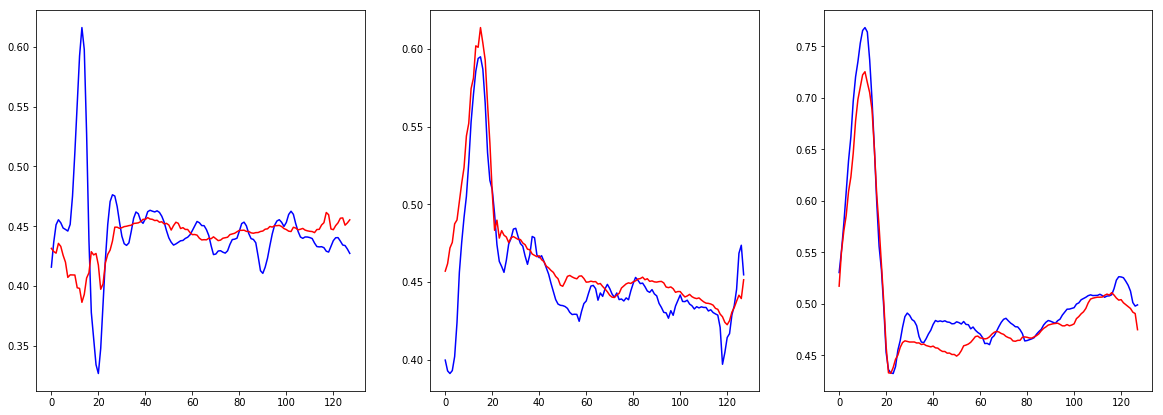

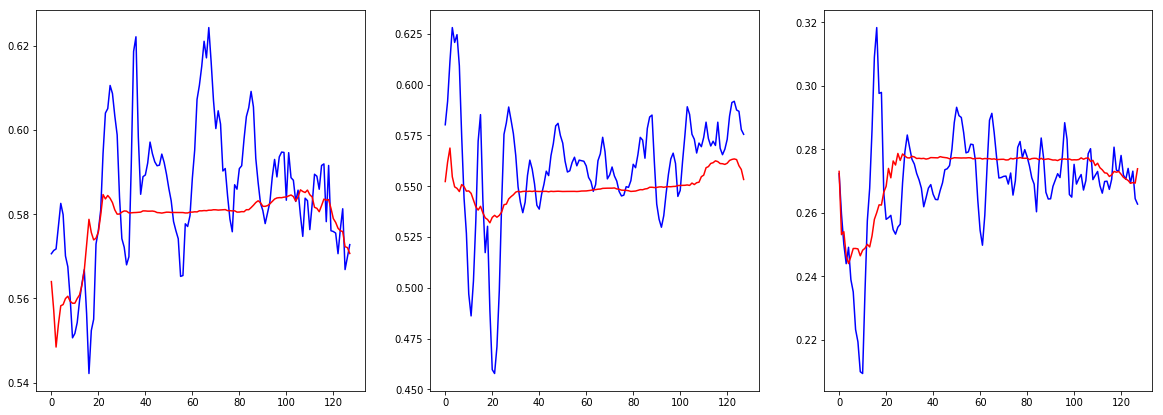

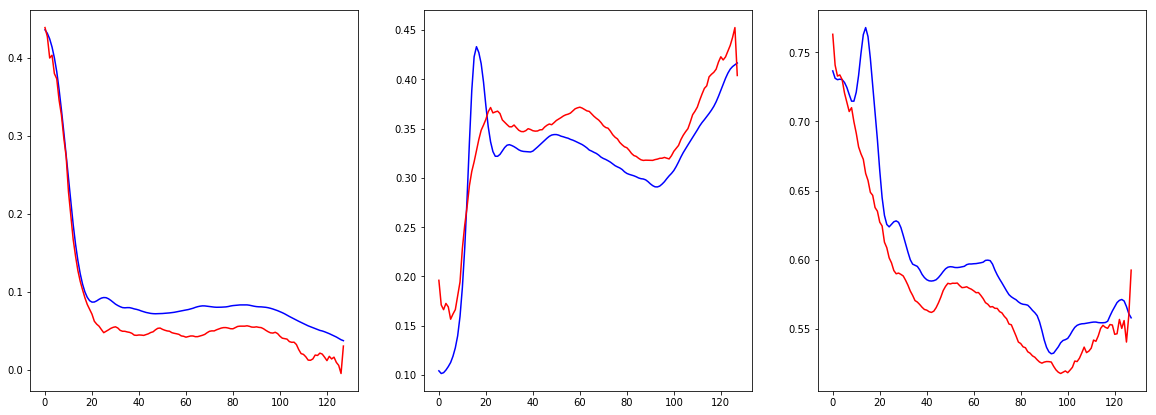

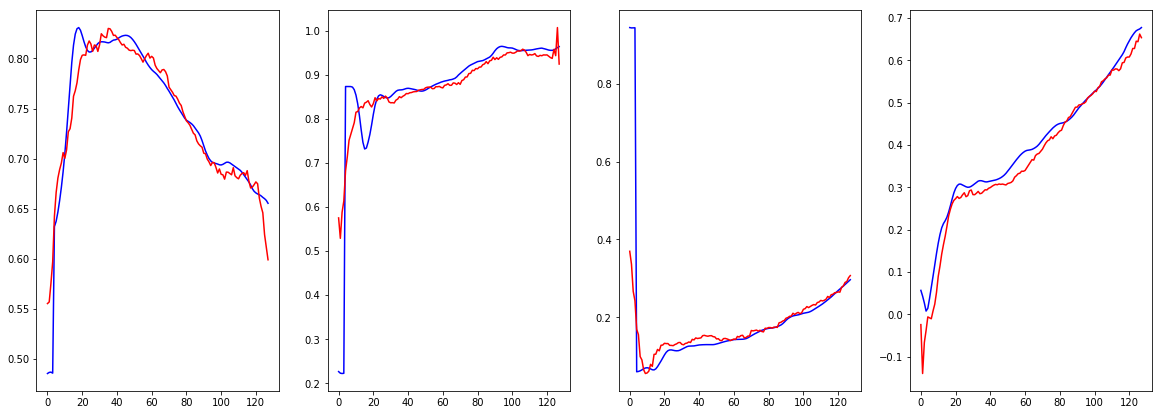

In [104]:
sample = 32
gyroy = gyroModel.predict(gyro_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gyro_train[sample,:,channel],'b')
    plot(gyroy[0,:,channel],'r')
linearAccy = linearAccModel.predict(linearAcc_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(linearAcc_train[sample,:,channel],'b')
    plot(linearAccy[0,:,channel],'r')
gravityy = gravityModel.predict(gravity_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gravity_train[sample,:,channel],'b')
    plot(gravityy[0,:,channel],'r')
gameVecy = gameVecModel.predict(gameVec_train[sample].reshape(1,128,4))
fig=plt.figure(figsize=(20,7))
for channel in range(4):
    plt.subplot(1,4,channel+1)
    plot(gameVec_train[sample,:,channel],'b')
    plot(gameVecy[0,:,channel],'r')